## TODO

1. ~~Implement perfect statevector simulation, for perfect kernel entries.~~ (introduced analytic formula for kernel elements)
2. ~~Implement a measure of peak width W($\gamma$)~~ (instead of width, its area seems to be ok)
3. ~~Implement a measure of average gradient value $\langle G \rangle$~~
4. Check the W($\gamma$) and $\langle G \rangle$ as a function of shot noise (number of shots)
5. ~~Check the W($\gamma$) and $\langle G \rangle$ as a function of N~~
6. ~~Check the W($\gamma$) and $\langle G \rangle$ as a function of perturbations of x~~

## Imports

In [1]:
import pandas as pd
#from pennylane 
import numpy as np
import matplotlib.pyplot as plt

import copy

from qiskit import Aer
from qiskit.algorithms.optimizers import SPSA

from qiskit import QuantumCircuit, assemble
from qiskit.visualization import plot_bloch_multivector, plot_histogram
from qiskit.circuit import Parameter

from matplotlib.colors import ListedColormap

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = [10,5]
plt.rcParams['font.size'] = 20

In [2]:
def matrix_target_alignment(K, Y, rescale_class_labels=True):
    if rescale_class_labels:
        nplus = np.count_nonzero(np.array(Y) == 1)
        nminus = len(Y) - nplus
        _Y = np.array([y / nplus if y == 1 else y / nminus for y in Y])
    else:
        _Y = np.array(Y)

    #####
    labels = _Y.copy()
    classes = np.unique(labels)
    centered_labels = (labels - classes.mean())
    _Y = np.array(centered_labels/centered_labels.max())
    #####

    T = np.outer(_Y, _Y)
    inner_product = np.sum(K * T)
    norm = np.sqrt(np.sum(K * K) * np.sum(T * T))
    inner_product = inner_product / norm

    return inner_product

In [3]:
def analytic_kernel_entry(x1, x2, gamma):
    return((np.cos(x1*gamma/2)*np.cos(x2*gamma/2)+np.sin(x1*gamma/2)*np.sin(x2*gamma/2))**2)

def get_analytic_kernel(x, gamma):
    kernel = np.zeros((len(x),len(x)))
    for i in range(len(x)):
        for j in range(i):
            x1_value = x[i]
            x2_value = x[j]
            #print("x1: ", x1_value, "x2: ", x2_value)
            kernel[i,j] = analytic_kernel_entry(x1= x1_value, x2= x2_value, gamma=gamma)
    kernel = kernel+np.transpose(kernel) + np.identity(len(x))
    return(kernel)

def analytic_TA(x,y,gamma):
    K = get_analytic_kernel(x, gamma)
    return(matrix_target_alignment(K, y))

## Setup

Creating the beads

In [3]:
N = 20
x = np.linspace(0,1,N)
y = (-1)**np.linspace(0,N-1,N)

In [4]:
sim = Aer.get_backend('aer_simulator')

In [5]:
def qubit_map(phi):
    qc = QuantumCircuit(1)
    qc.h(0)
    qc.p(phi, 0)
    qc.h(0)
    return(qc)

In [6]:
def kernel_map():
    x1 = Parameter('x1')
    x2 = Parameter('x2')
    phi = Parameter('Φ')
    qc = QuantumCircuit(1,1)
    qc.h(0)
    qc.p(phi*x1, 0)
    qc.p(-1.0*phi*x2,0)
    qc.h(0)
    qc.measure(0, 0)
    return(x1, x2, phi, qc)

In [7]:
def get_kernel_entry(qc, x1, x1_value, x2, x2_value, phi, phi_value, sim = Aer.get_backend('aer_simulator')): #, x1 = Parameter('x1'), x2 =  Parameter('x2'), phi = Parameter('Φ')
    qc_bound = qc.bind_parameters({x1:float(x1_value), x2:float(x2_value), phi:float(phi_value)})
    qobj = assemble(qc_bound)  # Assemble circuit into a Qobj that can be run
    counts = sim.run(qobj).result().get_counts()  # Do the simulation, returning the state vector
    if(counts.get('0')):
        kernel_element = counts.get('0')/(sum(counts[item] for item in counts))
    else:
        kernel_element = 0
    return(kernel_element)

In [8]:
x1, x2, phi, qc_test = kernel_map()

In [9]:
def get_kernel(x, phi_value):
    x1, x2, phi, qc_out = kernel_map()
    #return(qc_out.draw(output='mpl'))
    kernel = np.zeros((len(x),len(x)))
    for i in range(len(x)):
        for j in range(i):
            x1_value = x[i]
            x2_value = x[j]
            #print("x1: ", x1_value, "x2: ", x2_value)
            kernel[i,j] = get_kernel_entry(qc= qc_out, x1= x1, x1_value= x1_value, x2= x2, x2_value= x2_value, phi= phi, phi_value = phi_value)
    kernel = kernel+np.transpose(kernel) + np.identity(len(x))
    return(kernel)

In [10]:
def matrix_target_alignment(K, Y, rescale_class_labels=True):
    if rescale_class_labels:
        nplus = np.count_nonzero(np.array(Y) == 1)
        nminus = len(Y) - nplus
        _Y = np.array([y / nplus if y == 1 else y / nminus for y in Y])
    else:
        _Y = np.array(Y)

    #####
    labels = _Y.copy()
    classes = np.unique(labels)
    centered_labels = (labels - classes.mean())
    _Y = np.array(centered_labels/centered_labels.max())
    #####

    T = np.outer(_Y, _Y)
    inner_product = np.sum(K * T)
    norm = np.sqrt(np.sum(K * K) * np.sum(T * T))
    inner_product = inner_product / norm

    return inner_product

Target kernel alignment landscape

In [11]:
def loss(phi_val):
    return( - matrix_target_alignment(get_kernel(x, phi_val), y))

def analytic_TA(x,y,gamma):
    K = get_analytic_kernel(x, gamma)
    return(matrix_target_alignment(K, y))

In [25]:
startpoint = 0
endpoint = 2*np.pi*(N-1)
points_number = 150
param_test = np.linspace(startpoint,endpoint, points_number)

In [26]:
Target_a = []
for item in param_test:
    Target_a.append(-loss(item))

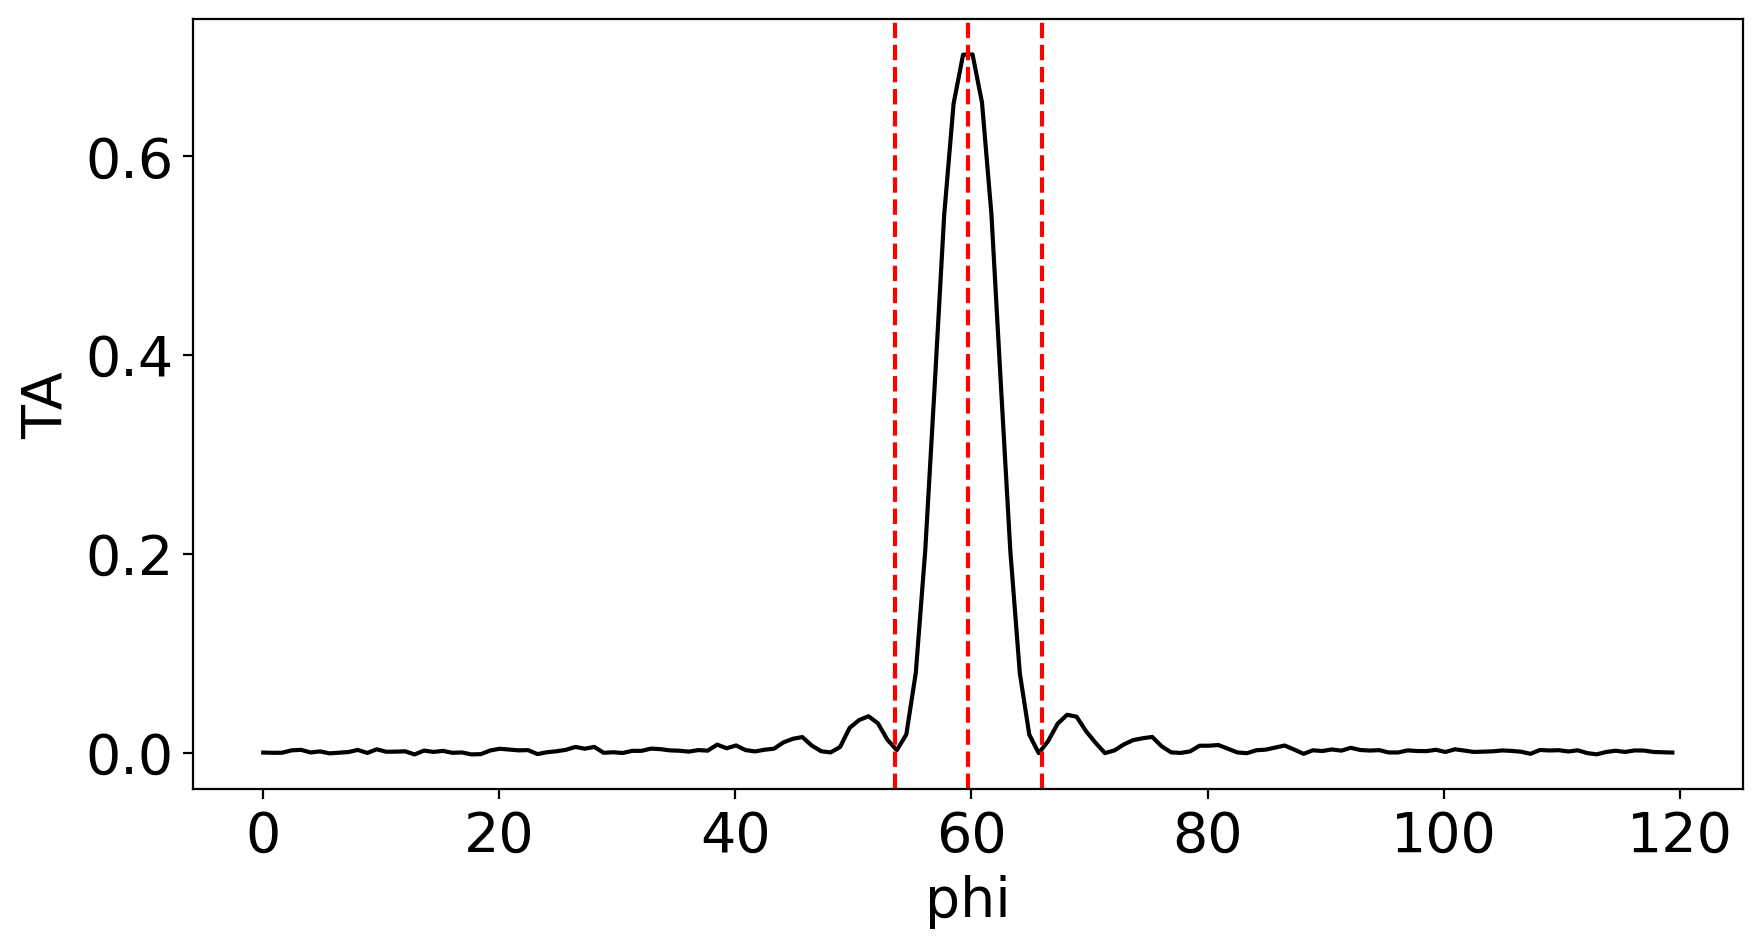

In [27]:
plt.plot(param_test, Target_a, c="k")
plt.xlabel("phi")
plt.ylabel("TA")
plt.axvline(x=np.pi*(N-1), c='red', linestyle='--')
plt.axvline(x=53.5, c='red', linestyle='--')
plt.axvline(x=66, c='red', linestyle='--')
plt.show()

# Analytic considerations

### N dependence

In [51]:
N = 32
x = np.linspace(0,1,N)
y = (-1)**np.linspace(0,N-1,N)

In [52]:
startpoint = 0
endpoint = 2*np.pi*(N-1)
points_number = 500
param_test = np.linspace(startpoint,endpoint, points_number)
a_TA = [analytic_TA(x,y,gamma) for gamma in param_test]

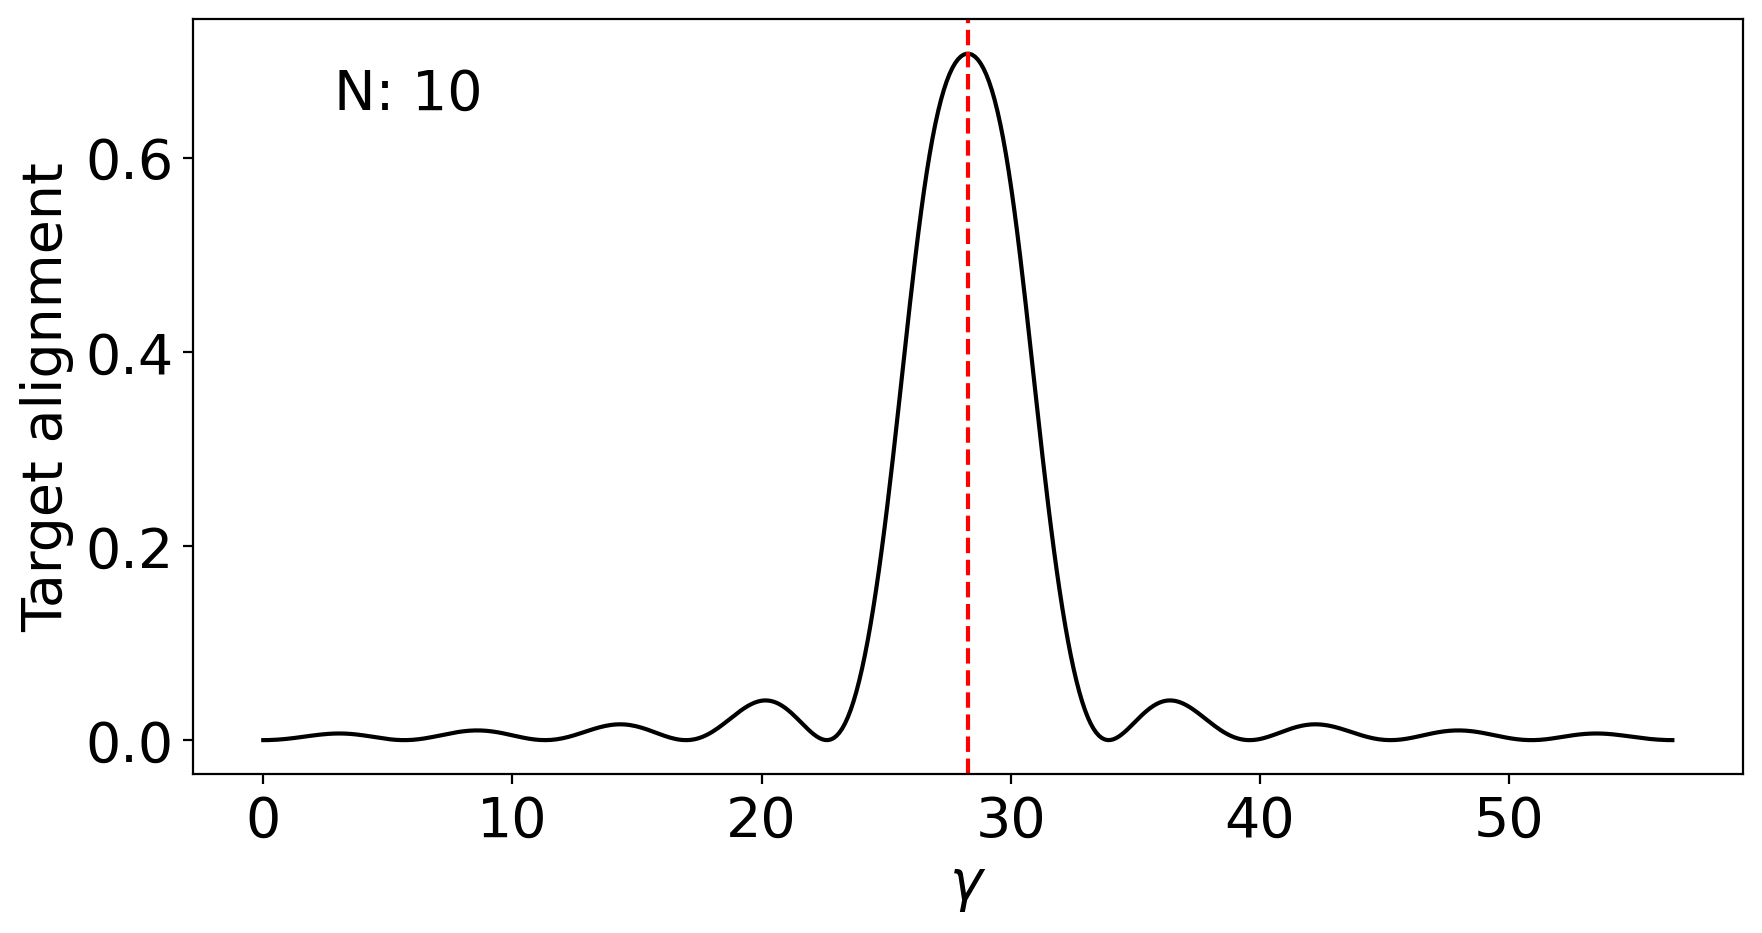

In [13]:
fig = plt.figure()
plt.plot(param_test, a_TA, c="k")
plt.xlabel(r'$\gamma$')
plt.ylabel("Target alignment")
plt.text(x=(0.05*param_test[-1]), y=0.65, s='N: '+str(N))
plt.axvline(x=np.pi*(N-1), c='red', linestyle='--')
plt.show()

In [14]:
def diff(x,y):
    difs = []
    x_step = x[1]-x[0]
    for i in range(len(x)-1):
        difs.append((y[i+1]-y[i])/x_step)
    return(difs)

In [15]:
def area(x, y):
    #Only for positive functions
    x_step = x[1]-x[0]
    A = 0
    for i in range(len(x)-1):
        A += y[i]*x_step + x_step*(y[i+1]-y[i])/2
    return(A)


In [46]:
def save_TA_plot(param_test, a_TA, N):
    #if(N<10):
    #    img_id = '00' + str(N)
    #elif(N<100):
    #    img_id = '0' + str(N)
    #else:
    #    img_id = str(N)
    img_id = str(N)
    fig = plt.figure(figsize=(18,10))
    plt.plot(param_test, a_TA, c="k")
    plt.xlabel(r'$\gamma$')
    plt.ylabel("TA")
    plt.text(x=(0.05*param_test[-1]), y=0.6, s='N: '+str(N), size = 40)
    #plt.axvline(x=np.pi*(N-1), c='red', linestyle='--')
    plt.savefig("images/TA-" + img_id + ".png")
    fig.clear()

In [53]:
save_TA_plot(param_test, a_TA, N)

<Figure size 3600x2000 with 0 Axes>

In [16]:
Ns = []
dens = []
var_diffs = []

for n in range(2,20):
    N = 2*n
    if(N%10==0): print(N)
    x = np.linspace(0,1,N)
    y = (-1)**np.linspace(0,N-1,N)
    startpoint = 0
    endpoint = 2*np.pi*(N-1)
    points_number = 1000
    param_test = np.linspace(startpoint,endpoint, points_number)
    a_TA = [analytic_TA(x,y,gamma) for gamma in param_test]
    dens.append(area(param_test, a_TA)/(param_test[-1]-param_test[0]))
    var_diffs.append(np.var(diff(param_test, a_TA)))
    Ns.append(N)
    #save_TA_plot(param_test=param_test, a_TA=a_TA, N=N)

10
20
30


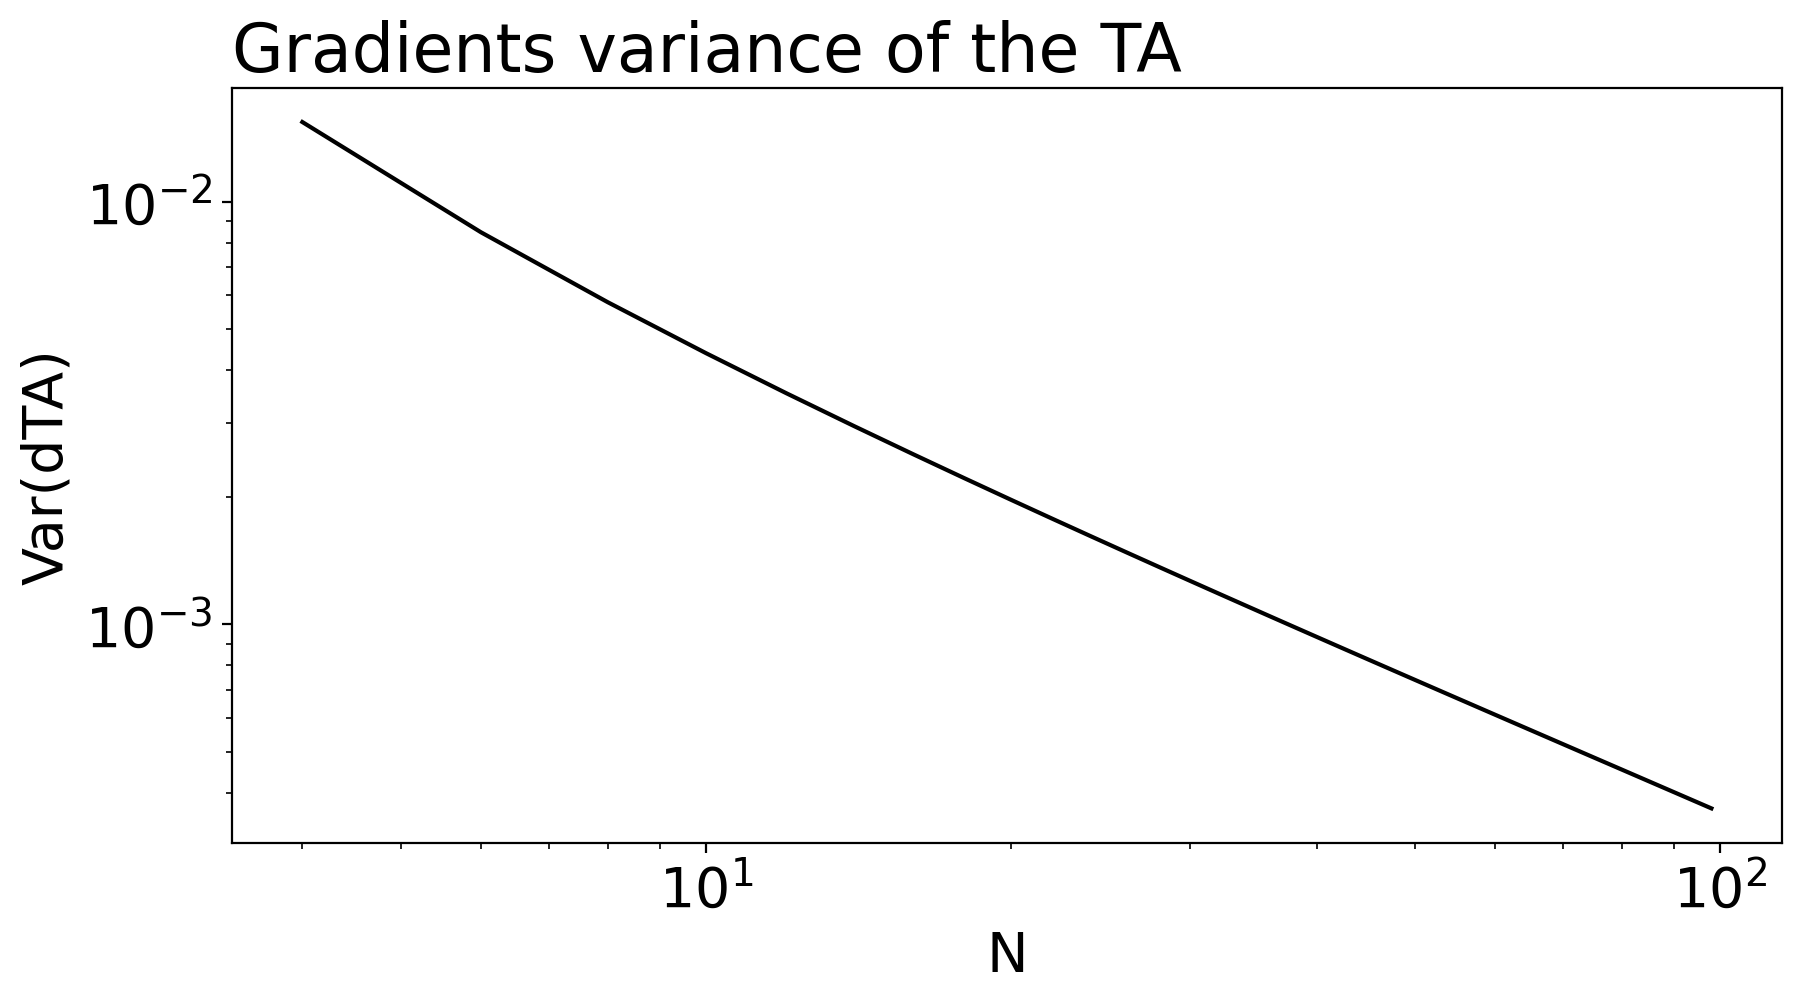

In [20]:
plt.plot(Ns,var_diffs, c='black')
plt.title('Gradients variance of the TA', loc='left')
plt.ylabel('Var(dTA)')
plt.xlabel('N')
plt.xscale('log')
plt.yscale('log')
plt.show()

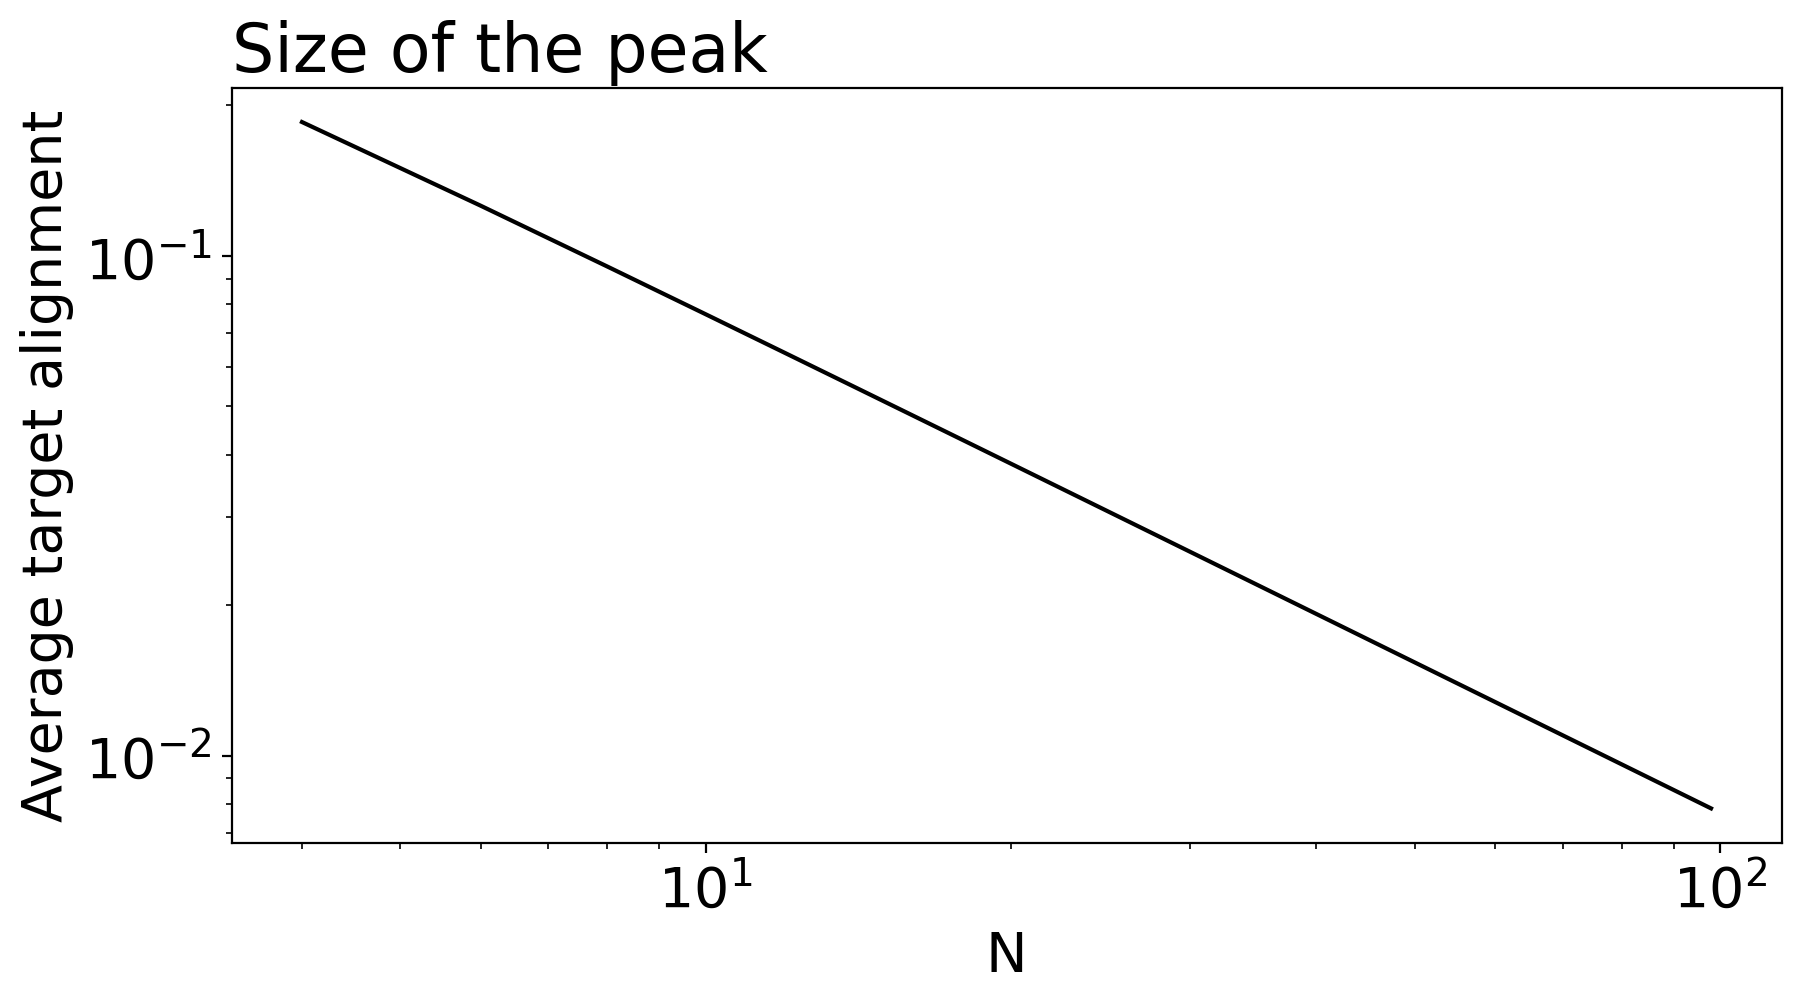

In [21]:
plt.plot(Ns,dens, c='black')
plt.title('Size of the peak', loc='left')
plt.ylabel('Average target alignment')
plt.xlabel('N')
plt.xscale('log')
plt.yscale('log')
plt.show()

In [19]:
for n in range(20,50):
    N = 2*n
    if(N%10==0): print(N)
    x = np.linspace(0,1,N)
    y = (-1)**np.linspace(0,N-1,N)
    startpoint = 0
    endpoint = 2*np.pi*(N-1)
    points_number = 1000
    param_test = np.linspace(startpoint,endpoint, points_number)
    a_TA = [analytic_TA(x,y,gamma) for gamma in param_test]
    dens.append(area(param_test, a_TA)/(param_test[-1]-param_test[0]))
    var_diffs.append(np.var(diff(param_test, a_TA)))
    Ns.append(N)

40
50
60
70
80
90


### Perts

In [162]:
N = 10
scale = 0.05
x_raw = np.linspace(0,1,N)
perts = np.random.normal(loc=0.0, scale=scale, size=x_raw.shape)
x = x_raw + perts
y = (-1)**np.linspace(0,N-1,N)
x_step = x_raw[1]-x_raw[0]

In [163]:
startpoint = 0
endpoint = 2*np.pi*(N-1)
points_number = 500
param_test = np.linspace(startpoint,endpoint, points_number)
a_TA = [analytic_TA(x,y,gamma) for gamma in param_test]
A = area(param_test, a_TA)/(param_test[-1]-param_test[0])
D = np.var(diff(param_test, a_TA))

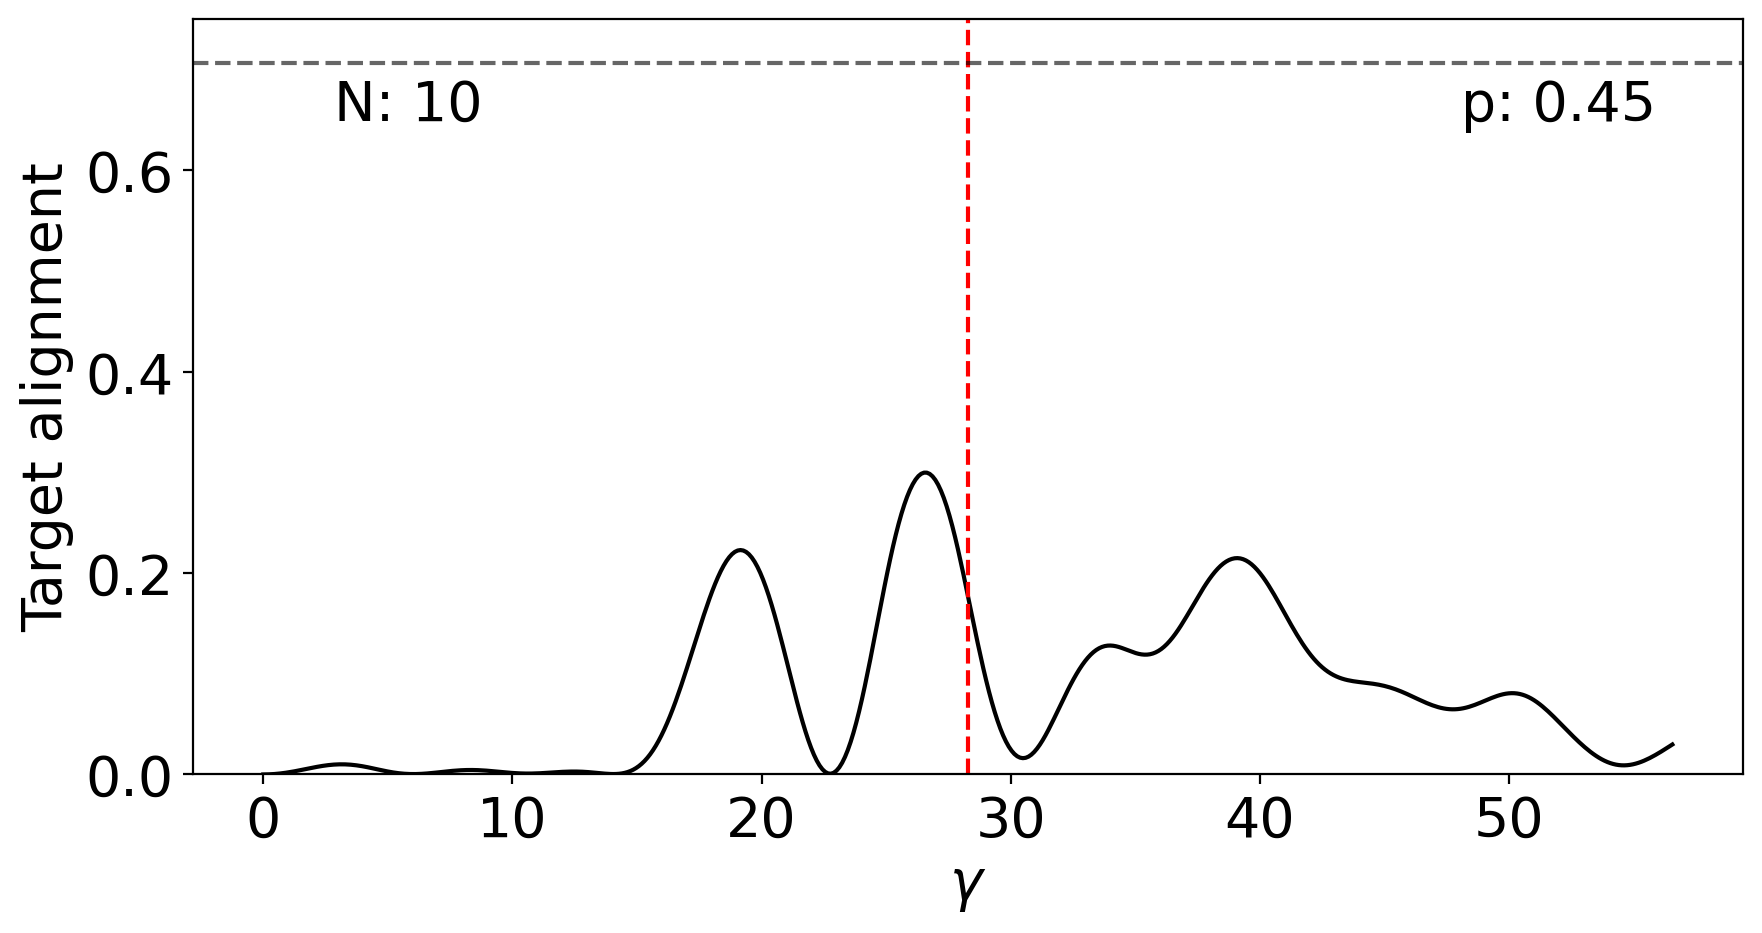

In [164]:
fig = plt.figure()
plt.plot(param_test, a_TA, c="k")
plt.xlabel(r'$\gamma$')
plt.ylabel("Target alignment")
plt.text(x=(0.05*param_test[-1]), y=0.65, s='N: '+str(N))
plt.text(x=(0.85*param_test[-1]), y=0.65, s='p: '+str(np.round(scale/x_step, decimals = 2)))
plt.axvline(x=np.pi*(N-1), c='red', linestyle='--')
plt.axhline(y=1/np.sqrt(2), c='black', linestyle='--', alpha = 0.6)
plt.ylim(0,0.75)
plt.show()

In [114]:
A = []
A_std = []
D = []
D_std = []
TA_max = []
TA_std = []

N = 10
startpoint = 0
endpoint = 2*np.pi*(N-1)
points_number = 500
p_min = 0.01
p_max = 0.3
p_no = 30
ps = np.linspace(p_min,p_max, p_no)


for p in ps:
    A_av = []
    D_av = []
    TA_max_av = []

    for _ in range(300):
        x_raw = np.linspace(0,1,N)
        perts = np.random.normal(loc=0.0, scale=p, size=x_raw.shape)
        x = x_raw + perts
        y = (-1)**np.linspace(0,N-1,N)
        param_test = np.linspace(startpoint,endpoint, points_number)
        a_TA = [analytic_TA(x,y,gamma) for gamma in param_test]
        A_av.append(area(param_test, a_TA)/(param_test[-1]-param_test[0]))
        D_av.append(np.var(diff(param_test, a_TA)))
        TA_max_av.append(np.array(a_TA).max())

    A.append(np.array(A_av).mean())
    A_std.append(np.array(A_av).std())
    D.append(np.array(D_av).mean())
    D_std.append(np.array(D_av).std())
    TA_max.append(np.array(TA_max_av).mean())
    TA_std.append(np.array(TA_max_av).std())
    


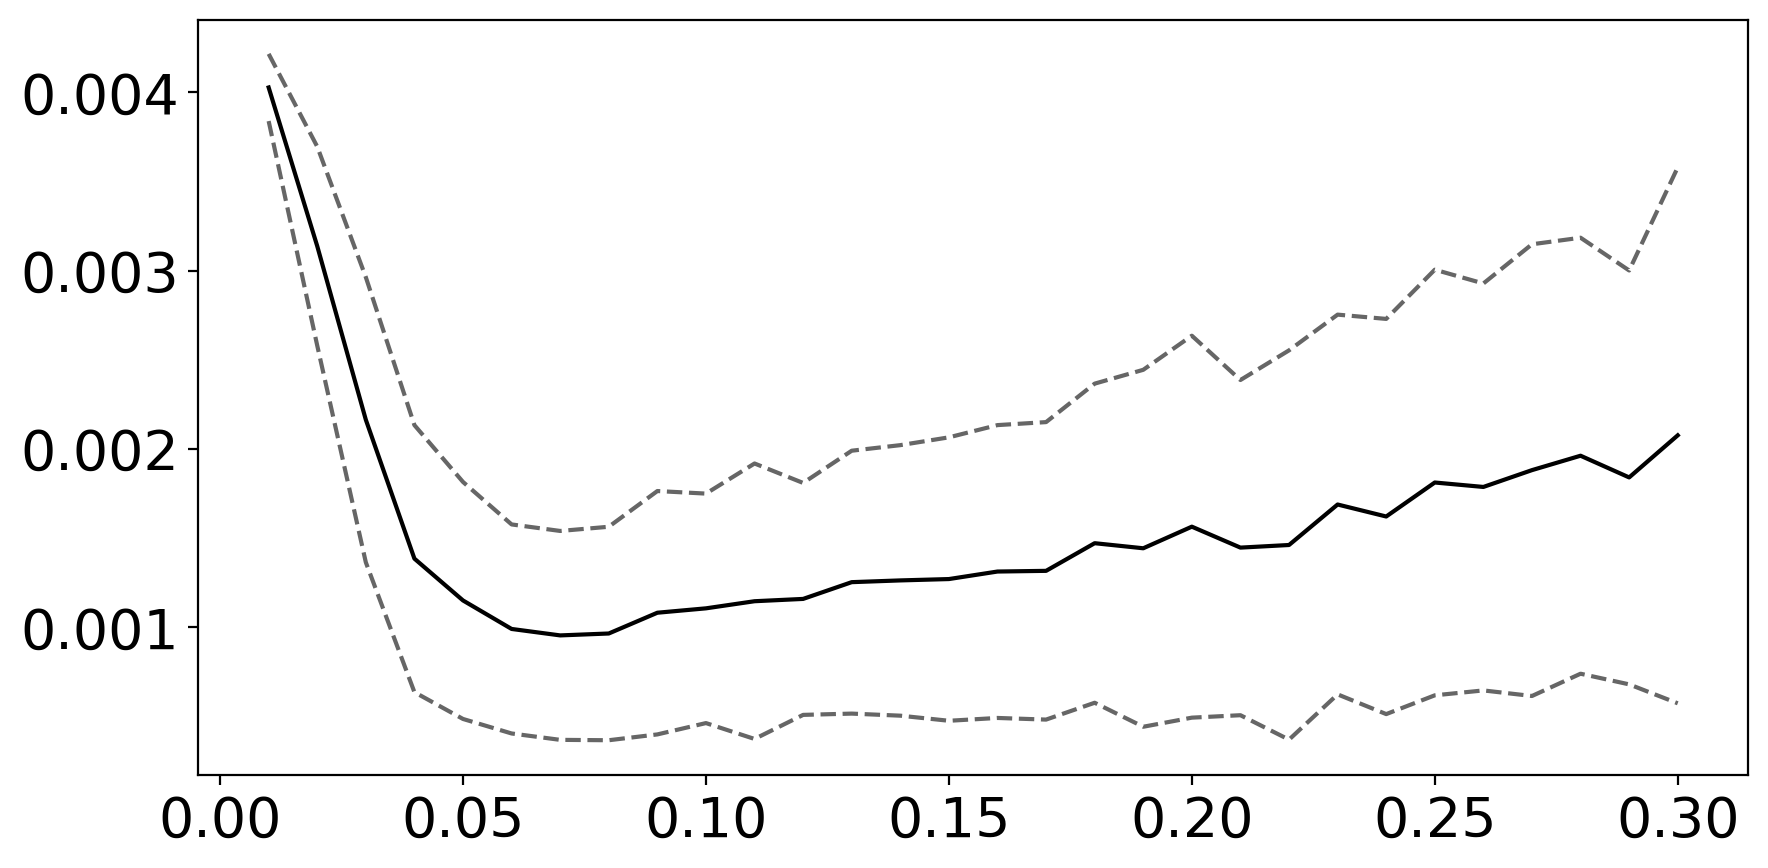

In [115]:
plt.plot(ps, D, c = 'black')
plt.plot(ps, np.array(D) + np.array(D_std), c = 'black', linestyle = '--', alpha = 0.6)
plt.plot(ps, np.array(D) - np.array(D_std), c = 'black', linestyle = '--', alpha = 0.6)
plt.show()

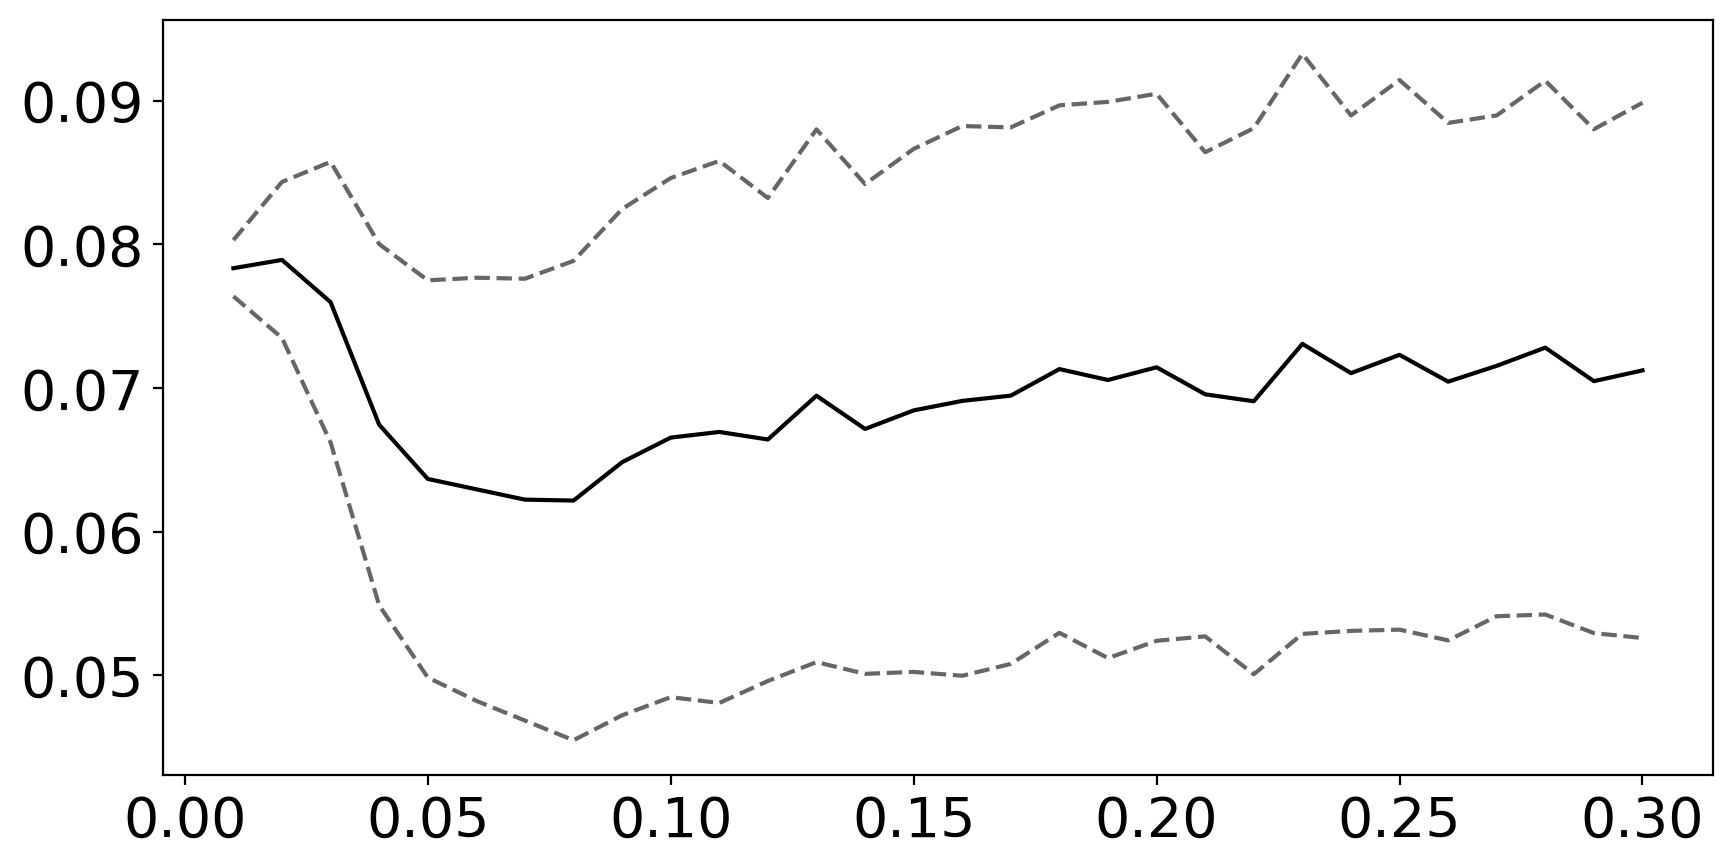

In [116]:
plt.plot(ps, A, c = 'black')
plt.plot(ps, np.array(A) + np.array(A_std), c = 'black', linestyle = '--', alpha = 0.6)
plt.plot(ps, np.array(A) - np.array(A_std), c = 'black', linestyle = '--', alpha = 0.6)
plt.show()

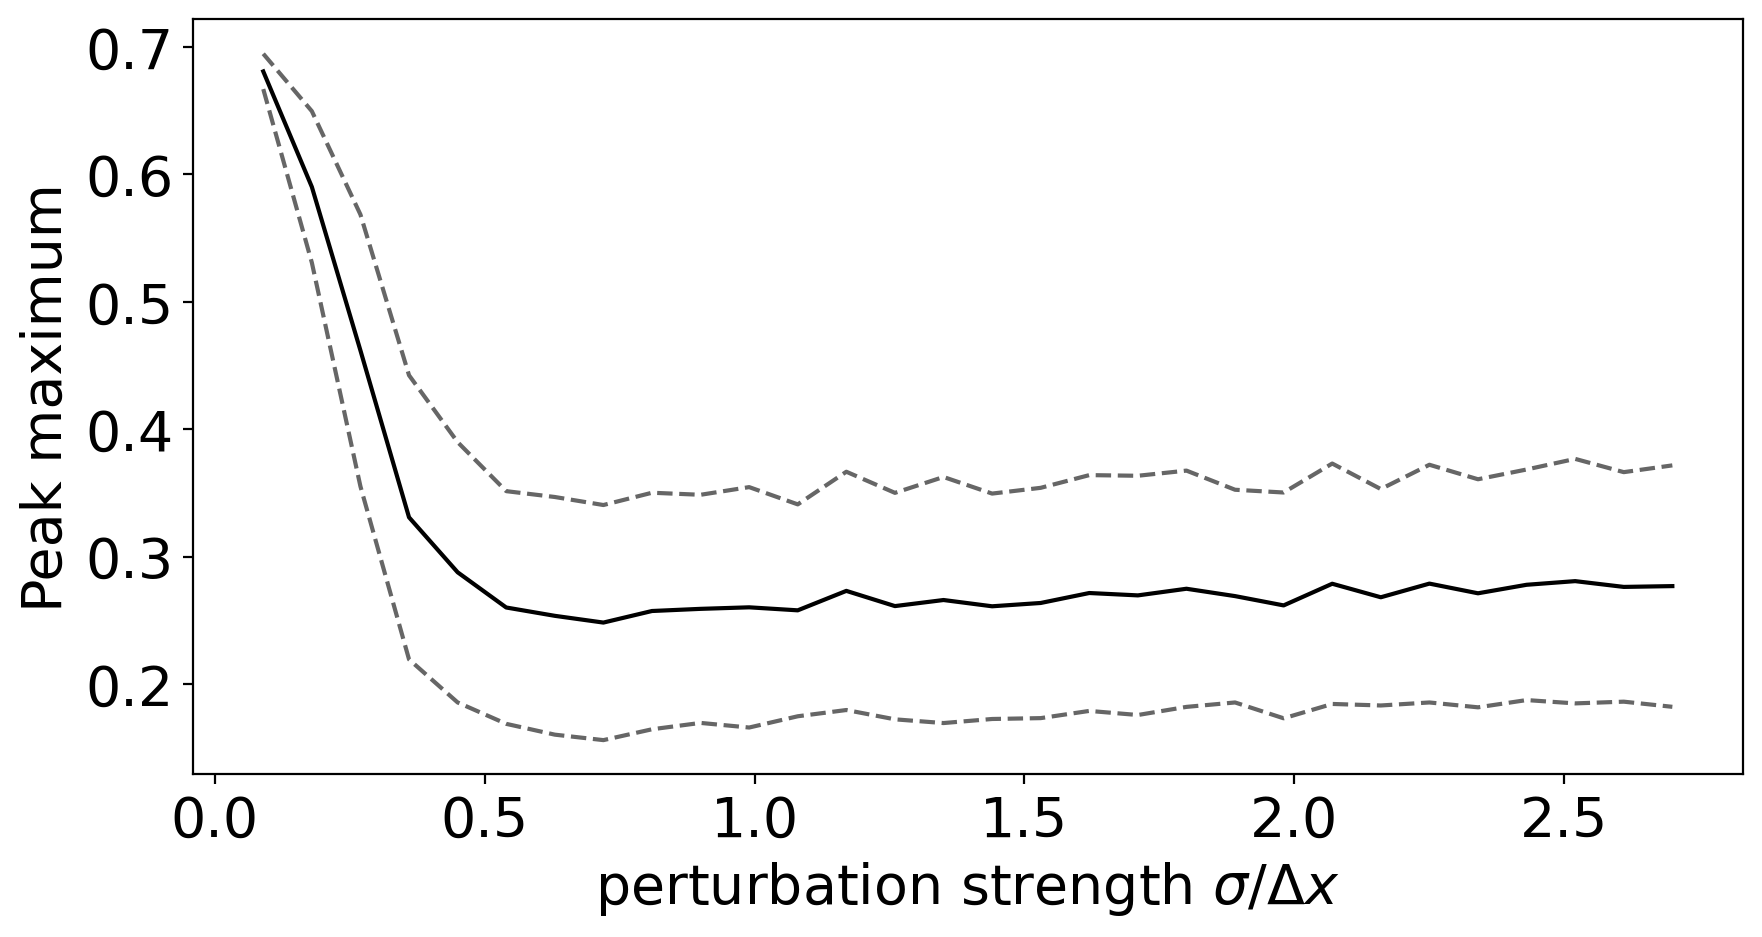

In [122]:
x_step = x_raw[1]-x_raw[0]

plt.plot(ps/x_step, TA_max, c = 'black')
plt.plot(ps/x_step, np.array(TA_max) + np.array(TA_std), c = 'black', linestyle = '--', alpha = 0.6)
plt.plot(ps/x_step, np.array(TA_max) - np.array(TA_std), c = 'black', linestyle = '--', alpha = 0.6)
plt.xlabel(r'perturbation strength $\sigma/\Delta x$')
plt.ylabel('Peak maximum')
plt.show()